In [1]:
import os
from pylbfgs import owlqn
import numpy as np
import scipy.ndimage as spimg
import scipy.fftpack as spfft
import matplotlib.pyplot as plt
%matplotlib inline

---------------------------------- ORIGINAL SIZE OF THE IMAGE: 0.08 MB
---------------------------------- SHAPE OF THE IMAGE: (280, 300)
---------------------------------- SHAPE OF THE SENSED IMAGE: (16800,)
---------------------------------- REDUCTED SIZE OF THE IMAGE: 0.016 MB
---------------------------------- REDUCTION: 80.0 % ( 84000  -->  16800 )
Step: 0.0
Original: [[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
Inverse 2D DCT of above [[  2.35452200e+02  -7.81425665e+01   4.72919010e+01 ...,   2.46989829e-01
    2.59886545e-01   2.53438364e-01]
 [ -7.81180922e+01   2.59260615e+01  -1.56904590e+01 ...,  -8.19460352e-02
   -8.62248946e-02  -8.40855235e-02]
 [  4.73060771e+01  -1.57000796e+01   9.50169213e+00 ...,   4.96241696e-02
    5.22153242e-02   5.09197824e-02]
 ..., 
 [  2.63994665e-01  -8.76153236e-02   5.30248160e-02 ..., 

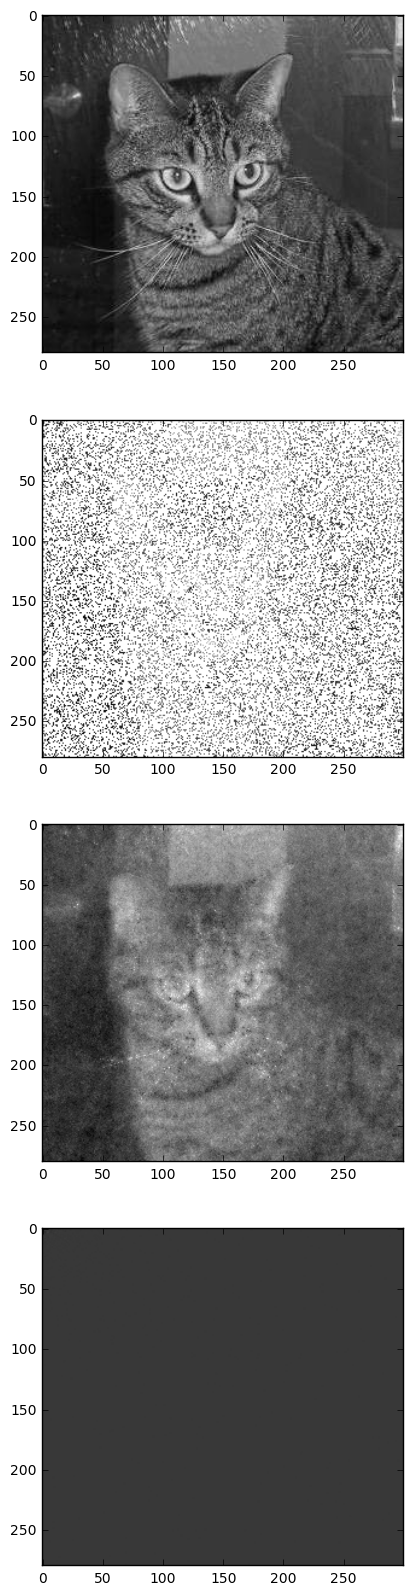

ValueError: too many values to unpack (expected 5)

In [3]:
_image_dims = None # track target image dimensions here
_ri_vector = None # reference the random sampling indices here
_b_vector = None # reference the sampled vector b here

def lbfgs(ORIG_IMAGE_PATH, verbose=1, progress_counter = 30):
    
    ### ALGORITHM PARAMS
    EVAL_METHOD = 1 # 1: in-memory dct2 version (fast, efficient for all size images)
    SCALE = 1  # Fraction to scale the original image
    SAMPLE = 0.2 # Fraction of the scaled image to randomly sample
    ORTHANTWISE_C = 5 # Coeefficient for the L1 norm of variables (see OWL-QN algorithm)

    ### HELPER FUNCTIONS
    def dct2(x):
        return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

    def idct2(x):
        return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

    def progress(x, g, fx, xnorm, gnorm, step, k, ls):
        if k % progress_counter == 0:
            print('Iteration {}'.format(k)); 
        return 0

    ### LBFGS
    def evaluate(x, g, step):
        """An in-memory evaluation callback."""
        # we want to return two things: 
        # (1) the norm squared of the residuals, sum((Ax-b).^2), and
        # (2) the gradient 2*A'(Ax-b)

        # expand x columns-first
        x2 = x.reshape((_image_dims[1], _image_dims[0])).T
        # Ax is just the inverse 2D dct of x2
        Ax2 = idct2(x2)
        if step == 0:
            print ('Step:', step)
            print ('Original:', x2)
            print ('Inverse 2D DCT of above', Ax2)
            
        # stack columns and extract samples
        Ax = Ax2.T.flat[_ri_vector].reshape(_b_vector.shape)
        # print ('x:', x.shape, 'x2:', x2.shape, ' Ax2:', Ax2.shape, ' Ax:', Ax.shape)
        # calculate the residual Ax-b and its 2-norm squared
        Axb = Ax - _b_vector
        fx = np.sum(np.power(Axb, 2))

        # project residual vector (k x 1) onto blank image (ny x nx)
        Axb2 = np.zeros(x2.shape)
        # print ('Axb2:', Axb2.shape, ' Axb:', Axb2.shape)
        Axb2.T.flat[_ri_vector] = Axb # fill columns-first

        # A'(Ax-b) is just the 2D dct of Axb2
        AtAxb2 = 2 * dct2(Axb2)
        if step == 0:
            print ('2D DCT:', dct2(Axb2))
        AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

        # copy over the gradient vector
        np.copyto(g, AtAxb)

        return fx  #Squared Error
    
    global _b_vector, _image_dims, _ri_vector

    
    ### IMAGE PROCESSING
    # read image in grayscale, then downscale it
    Xorig = spimg.imread(ORIG_IMAGE_PATH, flatten=True, mode='L') # read in grayscale
    print ('---------------------------------- ORIGINAL SIZE OF THE IMAGE:', round(np.size(Xorig)/1024.0/1024.0,3), 'MB')
    X = spimg.zoom(Xorig, SCALE)
    ny,nx = X.shape
    print ('---------------------------------- SHAPE OF THE IMAGE:', X.shape)
    # take random samples of image, store them in a vector b
    k = round(nx * ny * SAMPLE)
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
    b = X.T.flat[ri].astype(float) # important: cast to 64 bit
    print ('---------------------------------- SHAPE OF THE SENSED IMAGE:', b.shape)
    print ('---------------------------------- REDUCTED SIZE OF THE IMAGE:', round(np.size(b)/1024.0/1024.0,3), 'MB')
    orig_image_len = len(X.flat)
    sensed_image_len = b.shape[0]
    print ('---------------------------------- REDUCTION:', 100.0 * (orig_image_len - sensed_image_len)/(orig_image_len), '% (',orig_image_len,' --> ',sensed_image_len,')')
    #import sys; sys.exit(1)
    
    if EVAL_METHOD == 1:
        # This method evaluates the objective function sum((Ax-b).^2) and its 
        # gradient without ever actually generating A (which can be massive).
        # Our ability to do this stems from our knowledge that Ax is just the 
        # sampled idct2 of the spectral image (x in matrix form).
        # save image dims, sampling vector, and b vector and to global vars
        _image_dims = (ny, nx)
        _ri_vector = ri
        _b_vector = np.expand_dims(b, axis=1)
        # perform the L1 minimization in memory
        Xat2 = owlqn(nx*ny, evaluate, progress, ORTHANTWISE_C)   
        #f(x) = g(x) + C|x|1 -> f(x) = ||Ax-b||2 + C|x|1
        #delta ||Ax-b||2 = 2|Ax-b|A' 
        

    # transform the output back into the spatial domain
    X_transform = Xat2.reshape(nx, ny).T # stack columns
    X_spatial = idct2(X_transform)

    # create images of mask (for visualization)
    mask = np.zeros(X.shape)
    mask.T.flat[ri] = 255
    Xm = 255 * np.ones(X.shape)
    Xm.T.flat[ri] = X.T.flat[ri]

    ####
    print ('---------------------------------- ORIGINAL SIZE OF THE IMAGE:', round(np.size(Xorig)/1024.0/1024.0,3), 'MB')
    print ('---------------------------------- SHAPE OF THE IMAGE:', X.shape)
    print ('---------------------------------- SHAPE OF THE SENSED IMAGE:', b.shape)
    print ('---------------------------------- REDUCTED SIZE OF THE IMAGE:', round(np.size(b)/1024.0/1024.0,3), 'MB')
    print ('---------------------------------- REDUCTION:', 100.0 * (orig_image_len - sensed_image_len)/(orig_image_len), '% (',orig_image_len,' --> ',sensed_image_len,')')
    # display the result
    f, ax = plt.subplots(4, 1, figsize=(20, 20))
    cmap = 'gray'
    if cmap == 'hot':
        ax[0].imshow(X, cmap=cmap, interpolation='none')
        ax[1].imshow(Xm, cmap=cmap, interpolation='none')
        ax[2].imshow(Xa, cmap=cmap, interpolation='none')
    elif cmap == 'gray':
        ax[0].imshow(X, cmap=cmap)
        ax[1].imshow(Xm, cmap=cmap)
        ax[2].imshow(X_spatial, cmap=cmap)
        ax[3].imshow(X_transform, cmap=cmap)
    plt.show()
    
    return X, Xm, X_spatial, X_transform, f, ax


path = '/media/strider/779F028F19D9E33C/Cats vs Dogs/data/train/'
ORIG_IMAGE_PATH = path + 'cats/cat.1.jpg'
'/media/strider/77'
# ORIG_IMAGE_PATH = 'pylbfgs/test/testimage.png'
# ORIG_IMAGE_PATH = 'images/escher_waterfall.JPG'
# ORIG_IMAGE_PATH = 'me_trial1.jpg'
# ORIG_IMAGE_PATH = 'sample_image_1.jpg'
# ORIG_IMAGE_PATH = 'sample_image_2.jpg'
# ORIG_IMAGE_PATH = 'sample_image_3.jpg'
# ORIG_IMAGE_PATH = 'sample_image_4.jpg'

X, Xm, X_spatial, X_transform, f, ax = lbfgs(ORIG_IMAGE_PATH, verbose=0)

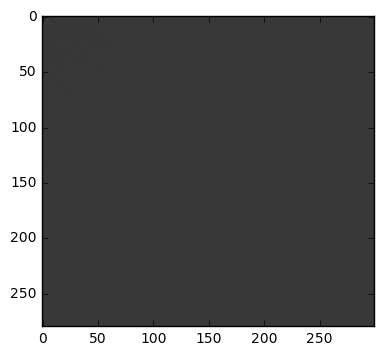

In [12]:
# print (X)              # Original Image
# print (X_spatial)      # Compress Sensed Image
# print (X_transform)    # Transform of the Original Image
plt.imshow(X, cmap=plt.cm.gray)
plt.savefig('Original_image.jpeg')

plt.imshow(X_spatial, cmap=plt.cm.gray)
plt.savefig('Compressed_sensed_image.jpeg')

plt.imshow(X_transform, cmap=plt.cm.gray)
plt.savefig('Original_image_transform.jpeg')

In [5]:
plt.savefig?